### Part I
- Generate a cubic spline interpolant from this pointwise data
- Normalize the function so that it is a PDF
- Use rejection sampling to choose neutron birth energies from this PDF

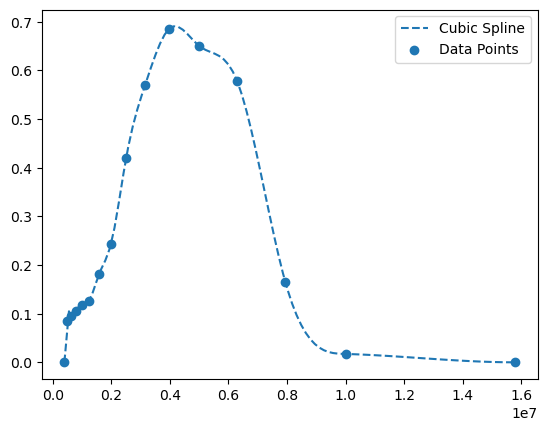

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import csv
emission = []
neutron_energy = []
with open("Neutron Intensity.csv", encoding='utf-8-sig') as csvfile:
    Neutron_Intensity = csv.reader(csvfile)
    for row in Neutron_Intensity: 
        emission.append(float(row[1]))
        neutron_energy.append(float(row[0]))

Cubic_spline = CubicSpline(neutron_energy,emission,bc_type='clamped')
x = np.linspace(3.98e5,1.58e7,100)
y = Cubic_spline(x)
    
plt.plot(x,y,linestyle="--",label="Cubic Spline")
plt.scatter(neutron_energy,emission,label="Data Points")
plt.legend()
plt.show()

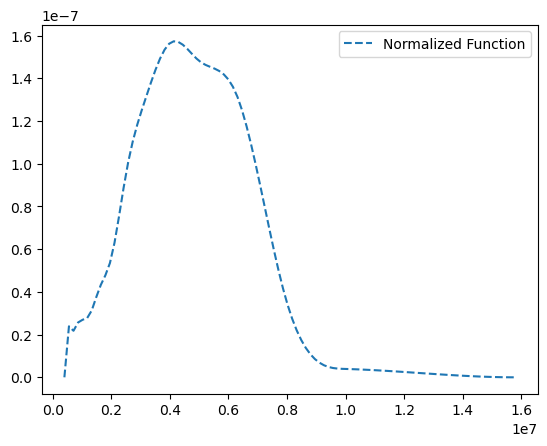

In [8]:
import decimal
decimal.getcontext().prec = 100
def RichExtrap(fh, fhn, n, k):
    """Compute the Richardson extrapolation based on
    two approximations of order k
    where the finite difference parameter h is used in fh and h/n in fhn.
    Inputs:
    fh: Approximation using h
    fhn: Approximation using h/n
    n: divisor of h
    k: original order of approximation
    Returns:
    Richardson estimate of order k+1"""
    n = decimal.Decimal(n)
    k = decimal.Decimal(k)
    numerator = decimal.Decimal(n**k * decimal.Decimal(fhn) - decimal.Decimal(fh))
    denominator = decimal.Decimal(n**k - decimal.Decimal(1.0))
    return float(numerator/denominator)

def trapezoid(f, a, b, pieces):
    """Find the integral of the function f between a and b
    using pieces trapezoids
    Args:
        f: function to integrate
        a: lower bound of integral
        b: upper bound of integral
        pieces: number of pieces to chop [a,b] into
    Returns:
        estimate of integral
    """
    integral = 0
    h = b - a
    #initialize the left function evaluation
    fa = f(a)
    for i in range(pieces):
        #evaluate the function at the left end of the piece
        fb = f(a+(i+1)*h/pieces)
        integral += 0.5*h/pieces*(fa + fb)
        #now make the left function evaluation the right for the next step
        fa = fb
    return integral

#Romberg Integration
#From book chapter 15 and lecture 13
def Romberg(f, a, b, MaxLevels = 10, epsilon = 1.0e-6, PrintMatrix = False):
    """Compute the Romberg integral of f from a to b
    Inputs:
    f:  integrand function
    a: left edge of integral
    b: right edge of integral
    MaxLevels: Number of levels to take the integration to
    
    Returns:
    Romberg integral estimate"""
    
    estimate = np.zeros((MaxLevels,MaxLevels))
    
    estimate[0,0] = trapezoid(f,a,b,pieces=1)
    count = 1
    converged = 0
    while not(converged):
        estimate[count,0] = trapezoid(f,a,b,pieces=2**count)
        for extrap in range(count):
            estimate[count,1+extrap] = RichExtrap(estimate[count-1,extrap], estimate[count,extrap],2,2**(extrap+1))
        
        converged = np.fabs(estimate[count,count] - estimate[count-1,count-1]) < epsilon
        if (count == MaxLevels-1): converged = 1
        count += 1
    if (PrintMatrix):
        print(estimate[0:count,0:count])
    return estimate[count-1, count-1]

interpolated_function = lambda x: Cubic_spline(x)

normalized_y = y / Romberg(interpolated_function, 0, 1.6e7)

plt.plot(x,normalized_y,linestyle="--",label="Normalized Function")
plt.legend()
plt.show()

In [54]:

def expfiss(x):
    return 0.453*np.exp(-1.036*x)*np.sinh(np.sqrt(2.29*x))

def birth_energy(energy,N):
        #make rejection box
        print("Starting birth energy func....")
        #min_eng = np.min(energy)
        #max_eng = np.max(energy)
        min_eng = np.min([np.min(energy),np.min(energy)])
        max_eng = np.max([np.max(energy),np.max(energy)])
        max_prob = np.max(expfiss(energy))/1000000000
        N = int(N)
        created = []
        for i in range(N):
            #compute energy via rejection sampling
            rejected = 1
            while (rejected):
                #pick x
                x = random.uniform(min_eng,max_eng)
                y = random.uniform(0,max_prob)
                rel_prob = expfiss(x)/1000000000
                if (y <= rel_prob):
                    energy = x
                    rejected = 0
            created.append(energy)
        print("Success?")
        return created
    
print(birth_energy(100, 50))

Starting birth energy func....
Success?
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


### Part II
Write a Monte Carlo neutron transport code to compute the energy dependent neutron flux as a function of position in the slab of soil

In [55]:
#do we need the lead file as well? para que?
cross_section_O16abs = []
energy_O16abs = []
with open("O16_abs.csv", encoding='utf-8-sig') as csvfile:
    O16_abs = csv.reader(csvfile)
    for row in O16_abs: 
        cross_section_O16abs.append(float(row[1]))
        energy_O16abs.append(float(row[0]))
O16_abs = [energy_O16abs,cross_section_O16abs]

cross_section_O16scat = []
energy_O16scat = []
with open("O16_scat.csv", encoding='utf-8-sig') as csvfile:
    O16_scat = csv.reader(csvfile)
    for row in O16_scat: 
        cross_section_O16scat.append(float(row[1]))
        energy_O16scat.append(float(row[0]))
O16_scat = [energy_O16scat,cross_section_O16scat]

cross_section_Si28scat = []
energy_Si28scat = []
with open("Si28_scat.csv", encoding='utf-8-sig') as csvfile:
    Si28_scat = csv.reader(csvfile)
    for row in Si28_scat: 
        cross_section_Si28scat.append(float(row[1]))
        energy_Si28scat.append(float(row[0]))
Si28_scat = [energy_Si28scat,cross_section_Si28scat]

cross_section_Si28abs = []
energy_Si28abs = []
with open("Si28_abs.csv", encoding='utf-8-sig') as csvfile:
    Si28_abs = csv.reader(csvfile)
    for row in Si28_abs: 
        cross_section_Si28abs.append(float(row[1]))
        energy_Si28abs.append(float(row[0]))
Si28_abs = [energy_Si28abs,cross_section_Si28abs]

cross_section_Al27abs = []
energy_Al27abs = []
with open("Al27_abs.csv", encoding='utf-8-sig') as csvfile:
    Al27_abs = csv.reader(csvfile)
    for row in Al27_abs: 
        cross_section_Al27abs.append(float(row[1]))
        energy_Al27abs.append(float(row[0]))
Al27_abs = [energy_Al27abs,cross_section_Al27abs]

cross_section_Al27scat = []
energy_Al27scat = []
with open("Al27_scat.csv", encoding='utf-8-sig') as csvfile:
    Al27_scat = csv.reader(csvfile)
    for row in Al27_scat: 
        cross_section_Al27scat.append(float(row[1]))
        energy_Al27scat.append(float(row[0]))
Al27_scat = [energy_Al27scat,cross_section_Al27scat]

cross_section_H1scat = []
energy_H1scat = []
with open("H1_scat.csv", encoding='utf-8-sig') as csvfile:
    H1_scat = csv.reader(csvfile)
    for row in H1_scat: 
        cross_section_H1scat.append(float(row[1]))
        energy_H1scat.append(float(row[0]))
H1_scat = [energy_H1scat,cross_section_H1scat]

cross_section_H1abs = []
energy_H1abs = []
with open("H1_abs.csv", encoding='utf-8-sig') as csvfile:
    H1_abs = csv.reader(csvfile)
    for row in H1_abs: 
        cross_section_H1abs.append(float(row[1]))
        energy_H1abs.append(float(row[0]))
H1_abs = [energy_H1abs,cross_section_H1abs]

cross_section_C12abs = []
energy_C12abs = []
with open("C12_abs.csv", encoding='utf-8-sig') as csvfile:
    C12_abs = csv.reader(csvfile)
    for row in C12_abs: 
        cross_section_C12abs.append(float(row[1]))
        energy_C12abs.append(float(row[0]))
C12_abs = [energy_C12abs,cross_section_C12abs]

cross_section_C12scat = []
energy_C12scat = []
with open("C12_scat.csv", encoding='utf-8-sig') as csvfile:
    C12_scat = csv.reader(csvfile)
    for row in C12_scat: 
        cross_section_C12scat.append(float(row[1]))
        energy_C12scat.append(float(row[0]))
C12_scat = [energy_C12scat,cross_section_C12scat]

In [78]:
import random
def energy_lookup(data_set, inp_energy):
    """look up energy in a data set and return the nearest energy in the table
        Input:
            data_set: a vector of energies
            inp_energy: the energy to lookup
        Output:
            index: the index of the nearest neighbor in the table
    """
    #argmin returns the indices of the smallest members of an array
    #here we’ll look for the minimum difference
    #between the input energy and the table
    index = np.argmin(np.fabs(data_set-inp_energy))
    return index

#convert lists into numpy arrays because it gives me issues otherwise
def read_csv_to_numpy(filename):
    energies = []
    cross_sections = []
    with open(filename, encoding='utf-8-sig') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            energies.append(float(row[0]))
            cross_sections.append(float(row[1]))
    return np.array(energies), np.array(cross_sections)

# load data from csv files
Si28_scat_energy, Si28_scat_cross_section = read_csv_to_numpy("Si28_scat.csv") 
Si28_abs_energy, Si28_abs_cross_section = read_csv_to_numpy("Si28_abs.csv")
O16_scat_energy, O16_scat_cross_section = read_csv_to_numpy("O16_scat.csv")
O16_abs_energy, O16_abs_cross_section = read_csv_to_numpy("O16_abs.csv")
Al27_scat_energy, Al27_scat_cross_section = read_csv_to_numpy("Al27_scat.csv")
Al27_abs_energy, Al27_abs_cross_section = read_csv_to_numpy("Al27_abs.csv")
H1_scat_energy, H1_scat_cross_section = read_csv_to_numpy("H1_scat.csv")
H1_abs_energy, H1_abs_cross_section = read_csv_to_numpy("H1_abs.csv")
C12_scat_energy, C12_scat_cross_section = read_csv_to_numpy("C12_scat.csv")
C12_abs_energy, C12_abs_cross_section = read_csv_to_numpy("C12_abs.csv")

def slab_source2(b_energy,Nx,w_oil,thickness,N, implicit_capture = True,cutoff=1.0e-3):
    print("does this function actually run??")
    """Compute the fraction of neutrons that leak through a slab
    Inputs:
    Nx:        The number of cells 
    Nen:       The number of energy groups
    w_oil:     Weight percentage of crude oil in soil
    thickness: Soil thickness
    N:         Number of neutrons histories
    implicit_capture: Do we run implicit capture
    cutoff: At what level do we stop implicit capture
    
    Returns:
    transmission:  The fraction of neutrons that made it through
    scalar_flux:   The scalar flux in each of the Nx cells
    scalar_flux_tl:   The scalar flux in each of the Nx cells from track length estimator
    X:             The value of the cell centers in the mesh
    """
    #for i in N_groups:
     #   Low_bin = float(input("Enter a value for the low value of the high energy interval:"))
      #  High_high_bin = float(input("Enter a value for the high value of the high energy interval:"))
       # Low_int_bin = float(input("Enter a value for the low value of the intermediate energy interval:"))
        #High_int_bin = float(input("Enter a value for the high value of the intermediate energy interval:"))
        #Low_low_bin = float(input("Enter a value for the low value of the low energy interval:"))
        #High_low_bin = float(input("Enter a value for the high value of the low energy interval:"))
    dx = thickness/Nx
    X = np.linspace(dx*0.5, thickness - 0.5*dx,Nx)
    scalar_flux = np.zeros(Nx)
    scalar_flux_tl = np.zeros(Nx)
    leak_left = 0.0#?
    leak_right = 0#?
    energy = birth_energy(b_energy,N)
    l = 0
    N = int(N)
    #N_en = int(Nen)
    weight = 1/N
    w_oil = float(w_oil)
    w_soil = 1-w_oil
    
    N_C = (w_oil*0.85*1.8)*(6.022*10**23)/12
    N_H = (w_oil*0.15*1.8)*(6.022*10**23)/1.00784
    N_O2_Si = ((w_soil*1.5*0.8*((2*15.99491461956)/(27.9769265 + 2*15.99491461956)))*6.022*10**23)/(2*15.99491461956)
    N_Si = (w_soil*1.5*0.8*(27.9769265/(27.9769265 + 2*15.99491461956))*6.022*10**23)/27.9769265
    N_Al = (w_soil*1.5*0.2*(26.9815384/(26.9815384 + 2*15.99491461956))*6.022*10**23)/26.9815384
    N_O2_Al = (w_soil*1.5*0.2*(2*15.99491461956/(26.9815384 + 2*15.99491461956))*6.022*10**23)/(2*15.99491461956)

    for i in range(N):
        print("Iteration number: ", N)
        alive = 1
        x = 0.0
        
        scat_index = energy_lookup(Si28_scat_energy*10E-24,energy[i]) # b to cm^2 --> *10E-24
        abs_index = energy_lookup(Si28_abs_energy*10E-24,energy[i])
        sigma_scat_Si = Si28_scat_cross_section[scat_index] *10E-24
        sigma_abs_Si = Si28_abs_cross_section[abs_index] *10E-24
        #Sig_t = cur_scat + cur_abs

        scat_index = energy_lookup(O16_scat_energy*10E-24,energy[i])
        abs_index = energy_lookup(O16_abs_energy*10E-24,energy[i])
        sigma_scat_O2 = O16_scat_cross_section[scat_index] *10E-24
        sigma_abs_O2 = O16_abs_cross_section[abs_index] *10E-24
            
        scat_index = energy_lookup(Al27_scat_energy*10E-24,energy[i])
        abs_index = energy_lookup(Al27_abs_energy*10E-24,energy[i])
        sigma_scat_Al = Al27_scat_cross_section[scat_index] *10E-24
        sigma_abs_Al = Al27_abs_cross_section[abs_index] *10E-24

        scat_index = energy_lookup(C12_scat_energy *10E-24,energy[i])
        abs_index = energy_lookup(C12_abs_energy *10E-24,energy[i])
        sigma_scat_C = C12_scat_cross_section[scat_index] *10E-24
        sigma_abs_C = C12_abs_cross_section[abs_index] *10E-24

        scat_index = energy_lookup(H1_scat_energy *10E-24,energy[i])
        abs_index = energy_lookup(H1_abs_energy *10E-24,energy[i])
        sigma_scat_H = H1_scat_cross_section[scat_index]*10E-24
        sigma_abs_H = H1_abs_cross_section[abs_index]*10E-24
        
        Sigma_scat = N_Si*sigma_scat_Si + N_O2_Si*sigma_scat_O2 + N_Al*sigma_scat_Al + N_O2_Al*sigma_scat_O2 + N_C*sigma_scat_C + N_H*sigma_scat_H
        Sigma_abs = N_Si*sigma_abs_Si + N_O2_Si*sigma_abs_O2 + N_Al*sigma_abs_Al + N_O2_Al*sigma_abs_O2 + N_C*sigma_abs_C + N_H*sigma_abs_H
        Sigma_t = Sigma_scat + Sigma_abs
        
        mu = np.random.uniform(-1,1)
        #which cell am I in
        cell = np.argmin(np.abs(X-x))
        while (alive):
            if (implicit_capture):
                if (weight < cutoff): #*weight
                    implicit_capture = False
                #get distance to collision
                if (Sigma_scat > 0):
                    l = -np.log(1-np.random.random())/Sigma_scat 
                else:
                    l = 10.0*thickness/np.abs(mu) #something that will make it through
                
            else:
                #get distance to collision
                l = -np.log(1-np.random.random())/Sigma_t
            #l = l[0] #make sure l is a scalar
            #compare distance to collision to distance to cell edge
            distance_to_edge = ((mu > 0.0)*( (cell+1)*dx - x) + (mu<0.0)*(x - cell*dx) + 1.0e-8)/np.abs(mu)
            if (distance_to_edge < l):
                l = distance_to_edge
                collide = 0
            else:
                collide = 1         
            #move particle
            x += l*mu
            #score track length tally
            if (implicit_capture):
                scalar_flux_tl[cell] += weight*(1.0 - np.exp(-l*Sigma_abs))/(Sigma_abs + 1.0e-14)
            else:
                scalar_flux_tl[cell] += weight*l
            if (implicit_capture):
                if not(l>=0):
                    print(l,x,mu,cell,distance_to_edge)
                assert(l>=0)
                weight_old = weight
                weight *= np.exp(-l*Sigma_abs)
            #still in the slab?
            if (np.abs(x-thickness) < 1.0e-14) or (x > thickness):
                leak_right += weight
                alive = 0
            elif (x<= 1.0e-14):
                alive = 0
                leak_left += weight
            else:
                #compute cell particle collision is in
                cell= np.argmin(np.abs(X-x))
                if (implicit_capture):
                    if (collide):
                        mu = np.random.uniform(-1,1,1)
                        rnd = np.random.uniform(0, 1)
                        if (random.random() < N_Si*sigma_scat_Si/Sigma_scat):
                            energy[i] = random.uniform(27.9769265*energy[i],energy[i])
                        elif (random.random() < (N_Si*sigma_scat_Si+N_O2_Si*sigma_scat_O2)/Sigma_scat):
                            energy[i] = random.uniform(15.99491461956*energy[i],energy[i])
                        elif (random.random() < (N_Al*sigma_scat_Al+N_Si*sigma_scat_Si+N_O2_Si*sigma_scat_O2)/Sigma_scat):
                            energy[i] = random.uniform(26.9815384*energy[i],energy[i])
                        elif (random.random() < (N_Al*sigma_scat_Al+N_Si*sigma_scat_Si+N_O2_Si*sigma_scat_O2+N_O2_Al*sigma_scat_O2)/Sigma_scat):
                            energy[i] = random.uniform(15.99491461956*energy[i],energy[i])
                        elif (random.random() < (N_Al*sigma_scat_Al+N_Si*sigma_scat_Si+N_O2_Si*sigma_scat_O2+N_O2_Al*sigma_scat_O2+N_C*sigma_scat_C)/Sigma_scat):
                            energy[i] = random.uniform(12*energy[i],energy[i])
                        else:
                            energy[i] = random.uniform(1.00784*energy[i],energy[i])  
                    scalar_flux[cell] += weight/Sigma_scat/dx
                else:
                    #scatter or absorb
                    scalar_flux[cell] += weight/Sigma_t/dx
                    if (collide):
                        if np.random.random() < (N_Si*(sigma_abs_Si+sigma_scat_Si))/Sigma_t:
                            if np.random.random() < N_Si*sigma_scat_Si/(N_Si*(sigma_abs_Si+sigma_abs_Si)):
                                energy = random.uniform(27.9769265*energy[i],energy[i])
                                mu = np.random.uniform(-1,1,1)
                            else: #absorbed
                                alive = 0
                        if np.random.random() < (N_O2_Si*(sigma_scat_O2+sigma_abs_O2)+N_Si*(sigma_abs_Si+sigma_scat_Si))/Sigma_t:#esta bien sumar?
                            if np.random.random() < N_O2_Si*sigma_scat_O2/(N_O2_Si*(sigma_scat_O2+sigma_abs_O2)):
                                energy = random.uniform(15.99491461956*energy[i],energy[i])
                                mu = np.random.uniform(-1,1,1)
                            else: #absorbed
                                alive = 0
                        if np.random.random() < (N_Al*(sigma_scat_Al+sigma_abs_Al)+N_O2_Si*(sigma_scat_O2+sigma_abs_O2)+N_Si*(sigma_abs_Si+sigma_scat_Si))/Sigma_t:#esta bien sumar?
                            if np.random.random() < N_Al*sigma_scat_Al/(N_Al*(sigma_scat_Al+sigma_abs_Al)):
                                mu = np.random.uniform(-1,1,1)
                                energy = random.uniform(26.9815384*energy[i],energy[i])
                            else: #absorbed
                                alive = 0
                        if np.random.random() < (N_O2_Al*(sigma_scat_O2+sigma_abs_O2)+N_Al*(sigma_scat_Al+sigma_abs_Al)+N_O2_Si*(sigma_scat_O2+sigma_abs_O2)+N_Si*(sigma_abs_Si+sigma_scat_Si))/Sigma_t:#esta bien sumar?
                            if np.random.random() < N_O2_Al*sigma_scat_O2/(N_O2_Al*(sigma_scat_O2+sigma_abs_O2)):
                                mu = np.random.uniform(-1,1,1)
                                energy = random.uniform(15.99491461956*energy[i],energy[i])
                            else: #absorbed
                                alive = 0
                        if np.random.random() < (N_C*(sigma_scat_C+sigma_scat_C)+N_O2_Al*(sigma_scat_O2+sigma_abs_O2)+N_Al*(sigma_scat_Al+sigma_abs_Al)+N_O2_Si*(sigma_scat_O2+sigma_abs_O2)+N_Si*(sigma_abs_Si+sigma_scat_Si))/Sigma_t:#esta bien sumar?
                            if np.random.random() < N_C*sigma_scat_C/(N_C*(sigma_scat_C+sigma_abs_C)):
                                mu = np.random.uniform(-1,1,1)
                                energy = random.uniform(12*energy[i],energy[i])
                            else: #absorbed
                                alive = 0
                        if np.random.random() < (N_H*(sigma_scat_H+sigma_abs_H)+N_C*(sigma_scat_C+sigma_scat_C)+N_O2_Al*(sigma_scat_O2+sigma_abs_O2)+N_Al*(sigma_scat_Al+sigma_abs_Al)+N_O2_Si*(sigma_scat_O2+sigma_abs_O2)+N_Si*(sigma_abs_Si+sigma_scat_Si))/Sigma_t:#esta bien sumar?
                            if np.random.random() < N_H*sigma_scat_H/(N_H*(sigma_scat_H+sigma_abs_H)):
                                mu = np.random.uniform(-1,1,1)
                                energy = random.uniform(1.00784*energy[i],energy[i])
                            else: #absorbed
                                alive = 0
            #print(x,mu,alive,l*mu,weight*l)
    return scalar_flux, scalar_flux_tl/dx

In [79]:
print("Can this even print?")
slab_source2(normalized_y,25,10,50,50,True,1.0e-3)


Can this even print?
does this function actually run??
Starting birth energy func....
Success?
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Iteration number:  50
Ite

C:\Users\alara\AppData\Local\Temp\ipykernel_20112\4281194760.py:148: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scalar_flux_tl[cell] += weight*(1.0 - np.exp(-l*Sigma_abs))/(Sigma_abs + 1.0e-14)
C:\Users\alara\AppData\Local\Temp\ipykernel_20112\4281194760.py:183: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scalar_flux[cell] += weight/Sigma_scat/dx


(array([0.49722093, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.43008065, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]))